### GraphRAG

The GraphRAG method is an advancement over the traditional RAG approach, incorporating a graph database to enrich contextual information provided to the Language Model (LLM). Unlike merely sending textual excerpts from documents, which may lack context and accuracy, Graph RAG integrates structured entity information, including textual descriptions, properties, and relationships. This deeper context enhances the LLM's understanding of received data, enabling better insights into subject domains. By combining the strengths of graph representation with textual content, GraphRAG offers a comprehensive approach to understanding and processing information.

### Installing Libraries

In [1]:
# !pip install openai
# !pip install wikipedia
# !pip install langchain
# !pip install langchain-openai

### Importing Libraries

In [7]:
# Import the os module to interact with the operating system
import os
import yaml
# Import NetworkX, a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks
import networkx as nx

# Import matplotlib.pyplot for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt

# Import LLMChain from langchain.chains, a class for creating language model chains
from langchain.chains import LLMChain

# Import ChatOpenAI from langchain_openai, a class for integrating with OpenAI's language models
# from langchain_openai import ChatOpenAI

# Import GraphQAChain from langchain.chains, a class for creating question-answering chains over graph data structures
from langchain.chains import GraphQAChain

# Import ChatPromptTemplate from langchain.prompts, a class for creating chat prompt templates
from langchain.prompts import ChatPromptTemplate

# Import SimpleSequentialChain from langchain.chains, a class for creating simple sequential chains
from langchain.chains import SimpleSequentialChain



# Import KnowledgeTriple from langchain.graphs.networkx_graph, a class for representing knowledge triples in a graph
from langchain.graphs.networkx_graph import KnowledgeTriple

### Loading OpenAI API Key

In [2]:
with open('chatgpt_api_credentials.yml', 'r') as file:
    api_creds = yaml.safe_load(file)
    

In [3]:
os.environ['GOOGLE_API_KEY'] = api_creds['gemini_api_key']

### Introduction to Knowledge Graph

We are going to extract information from Wikipedia, in the format of a knowledge graph. A knowledge graph is a representation of information (knowledge). It requires to identify, in a triplet format:

- the head entity
- the relation
- the tail entity

In [5]:
from IPython.display import Image
#Image("kg_extraction.png")

### Searching on Wikipedia

In [10]:
!pip install wikipedia

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11707 sha256=b40705cd9e7d6fdf23bddfe0b3e49297c12a7fc9c788749dcec0fdf0ccba93f4
  Stored in directory: c:\users\sridharnomula\appdata\local\pip\cache\wheels\8f\ab\cb\45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [11]:
# Import WikipediaAPIWrapper from langchain.utilities, a utility class for interacting with Wikipedia's API
from langchain.utilities import WikipediaAPIWrapper

In [12]:
# Initialize a WikipediaAPIWrapper instance with a specified number of top results to return (in this case, 1)
wikipedia = WikipediaAPIWrapper(top_k_results = 1)

# Use the run method of the WikipediaAPIWrapper instance to fetch information about 'Tesla, Inc.' and print the result
print(wikipedia.run('APJ Abdul Kalam'))

Page: A. P. J. Abdul Kalam
Summary: Avul Pakir Jainulabdeen Abdul Kalam BR ( ; 15 October 1931 – 27 July 2015) was an Indian aerospace scientist and statesman who served as the 11th president of India from 2002 to 2007. He was born and raised in Rameswaram, Tamil Nadu and studied physics and aerospace engineering. He spent the next four decades as a scientist and science administrator, mainly at the Defence Research and Development Organisation (DRDO) and Indian Space Research Organisation (ISRO) and was intimately involved in India's civilian space programme and military missile development efforts. He thus came to be known as the Missile Man of India for his work on the development of ballistic missile and launch vehicle technology. He also played a pivotal organisational, technical, and political role in India's Pokhran-II nuclear tests in 1998, the first since the original nuclear test by India in 1974.
Kalam was elected as the 11th president of India in 2002 with the support of bo

### Defining Prompt Templates and LLMChains

### Template 1

In [13]:
# Define a template string for generating a refined document. 
# The template includes instructions for the refined document's content, criteria, and a placeholder for the document's content.
first_template = """Please generate a refined document of the following document. \n\
And please ensure that the refined document meets the following criteria: \n\
1. The refined document should be abstract and does not change any original \
meaning of the document. \n\
2. The refined document should retain all the important objects, concepts, and \
relationship between them. \n\
3. The refined document should only contain information that is from \
the document. \n\
4. The refined document should be readable and easy to understand without any \
abbrevations and misspellings. \n\
Here is the content: {content}
"""

# Create a ChatPromptTemplate instance from the defined template string. 
# This instance can be used to format messages for a chat model, such as generating a refined document based on the provided template.
first_prompt = ChatPromptTemplate.from_template(first_template)

In [14]:
first_prompt # these are instructions only

ChatPromptTemplate(input_variables=['content'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['content'], template='Please generate a refined document of the following document. \nAnd please ensure that the refined document meets the following criteria: \n1. The refined document should be abstract and does not change any original meaning of the document. \n2. The refined document should retain all the important objects, concepts, and relationship between them. \n3. The refined document should only contain information that is from the document. \n4. The refined document should be readable and easy to understand without any abbrevations and misspellings. \nHere is the content: {content}\n'))])

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [19]:
# Initialize a Gemini instance with a temperature of 0.0, which means the responses will be very deterministic and straightforward.
gemini_model = ChatGoogleGenerativeAI(model="gemini-pro",temperature=0.0,
                                      convert_system_message_to_human=True)



Create an LLMChain instance using the previously defined ChatPromptTemplate as the prompt and the Gemini instance as the language model.
This chain is configured to generate responses based on the template, with the deterministic behavior controlled by the temperature setting.


In [20]:
first_chain = LLMChain(
    prompt = first_prompt,
    llm = gemini_model
)

### Template 2

In [21]:
# Define a template string for extracting a knowledge graph from a given text. 
# The template outlines the steps for identifying entities, relationships, and summarizing them into a knowledge graph format. It also specifies the format for the output and a fallback message if no knowledge can be extracted.
second_template = """You are a knowledge graph extractor, and your task is to extract\
and return a knowledge graph from a given text. Let's extract it step by step:\n\
(1). Identify the entities in the text. An entity can be a noun or noun phrase \
that refers to a real-world object or an abstract concept. You can use a named entity\
recognition (NER) tool or a part-of-speech (POS) tagger to identify the entities. \n\
(2). Identify the relationships between the entities. A relationship can be a verb \
or a prepositional phrase that connects two entities. You can use dependency parsing \
to identify the relationships. \n\
(3). Summarize each entity and relation as short as possible and remove any stop words. \n\
(4). Only return the knowledge graph in the triplet format: ('head entity', 'relation', 'tail entity'). \n\
(5). Most importantly, if you cannot find any knowledge, please just output: "None". \n\
Here is the content: {content} 
"""

# Create a ChatPromptTemplate instance from the defined template string. 
# This instance is used to format messages for a chat model, specifically for the task of extracting a knowledge graph from a given text based on the provided template.
second_prompt = ChatPromptTemplate.from_template(second_template)

# Create an LLMChain instance using the previously defined ChatPromptTemplate as the prompt and the ChatOpenAI instance as the language model. 
# This chain is configured to generate responses based on the template, aiming to extract structured information in the form of a knowledge graph from the input text.
second_chain = LLMChain(
    prompt = second_prompt,
    llm = gemini_model
)

Create an instance of `SimpleSequentialChain`, which is a type of chain that executes multiple chains sequentially. 
This instance is configured with two chains: 
- first_chain and second_chain.
- The 'verbose' parameter is set to True, indicating that detailed logging or output will be provided during the execution of the chains.
 <br><br>
 This setup allows for a sequential execution of tasks, where the output of the first chain is used as input for the second chain, facilitating complex 
workflows or multi-step processes.

In [22]:
overall_chain = SimpleSequentialChain(
    chains = [first_chain, second_chain],
    verbose = True
)

# Fetching Data and Creating Knowledge Graph

In [23]:
# Initialize the Wikipedia API wrapper with a limit of 1 result per query
wikipedia = WikipediaAPIWrapper(top_k_results=1)

# Fetch the top result for the query 'Tesla, Inc.'
wiki_pages = wikipedia.run('APJ Abdul Kalam')

In [24]:
wiki_pages

'Page: A. P. J. Abdul Kalam\nSummary: Avul Pakir Jainulabdeen Abdul Kalam BR ( ; 15 October 1931 – 27 July 2015) was an Indian aerospace scientist and statesman who served as the 11th president of India from 2002 to 2007. He was born and raised in Rameswaram, Tamil Nadu and studied physics and aerospace engineering. He spent the next four decades as a scientist and science administrator, mainly at the Defence Research and Development Organisation (DRDO) and Indian Space Research Organisation (ISRO) and was intimately involved in India\'s civilian space programme and military missile development efforts. He thus came to be known as the Missile Man of India for his work on the development of ballistic missile and launch vehicle technology. He also played a pivotal organisational, technical, and political role in India\'s Pokhran-II nuclear tests in 1998, the first since the original nuclear test by India in 1974.\nKalam was elected as the 11th president of India in 2002 with the support 

In [25]:
# Execute the overall chain with the fetched Wikipedia pages as input
overall_chain.run(wiki_pages)

C:\Users\SridharNomula\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new SimpleSequentialChain chain...
**Abstract**

Avul Pakir Jainulabdeen Abdul Kalam, known as the "Missile Man of India," was an esteemed aerospace scientist and statesman who served as India's 11th President from 2002 to 2007.

**Key Concepts and Relationships**

* **Aerospace Scientist:** Kalam's expertise in physics and aerospace engineering led to his involvement in India's space program and missile development.
* **Missile Man of India:** He played a crucial role in the development of ballistic missiles and launch vehicle technology.
* **Pokhran-II Nuclear Tests:** Kalam's organizational and technical contributions were instrumental in India's 1998 nuclear tests.
* **People's President:** Kalam's presidency was marked by his popularity and connection with the Indian people.
* **Legacy:** After his presidency, Kalam continued to inspire through education, writing, and public service.

**Important Objects**

* **Defence Research and Development Organisation (DRDO)**
* 

"('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Aerospace Scientist')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Missile Man of India')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'People's President')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', '11th President of India')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Recipient of Bharat Ratna')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'President of India')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Statesman')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Esteemed')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Scientist')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Missile Man')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'People's')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'President')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Statesman')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Esteemed')\n('Avul Pakir Jainulabdeen Abdul Kalam', 'is', 'Scientist')\n('Avul Pakir Jainulabdeen Abdul

This line of code dynamically evaluates and processes a chain of expressions (triples) obtained from running a function (overall_chain) on a set of wiki pages (wiki_pages). <br>
It splits the output by newline characters, filters out empty strings, and evaluates each non-empty string as a Python expression using eval().<br>
The result is a list of evaluated expressions (triples), which are then stored in the variable list_of_triples.

In [26]:
list_of_triples = [eval(t) for t in overall_chain.run(wiki_pages).split('\n') if t]



> Entering new SimpleSequentialChain chain...
**Abstract**

Avul Pakir Jainulabdeen Abdul Kalam, known as the "Missile Man of India," was an esteemed aerospace scientist and statesman who served as India's 11th President from 2002 to 2007.

**Key Concepts and Relationships**

* **Aerospace Scientist:** Kalam's expertise in physics and aerospace engineering led to his involvement in India's space and missile programs.
* **Missile Development:** He played a crucial role in developing India's ballistic missile and launch vehicle technology.
* **Nuclear Tests:** Kalam's contributions to India's Pokhran-II nuclear tests in 1998 were significant.
* **Presidential Tenure:** Elected with bipartisan support, Kalam served as President from 2002 to 2007, earning the title "People's President."
* **Legacy:** After his presidency, Kalam continued his work in education, writing, and public service. He received numerous awards, including the Bharat Ratna, India's highest civilian honor.
* **Death a

In [27]:
# inspecting the triples for any errors qualitatively
list_of_triples

[('Avul Pakir Jainulabdeen Abdul Kalam', 'profession', 'Aerospace Scientist'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'role', 'Missile Development'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'contribution', 'Nuclear Tests'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'tenure', 'Presidential Tenure'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'legacy', 'Legacy'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'death', 'Death and Funeral')]

In [29]:
list_of_triples = [item for item in list_of_triples if item is not None]
list_of_triples

[('Avul Pakir Jainulabdeen Abdul Kalam', 'profession', 'Aerospace Scientist'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'role', 'Missile Development'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'contribution', 'Nuclear Tests'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'tenure', 'Presidential Tenure'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'legacy', 'Legacy'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'death', 'Death and Funeral')]

This line filters the list_of_triples to include only those triples that have exactly three elements.
It uses a list comprehension to iterate over each triple in list_of_triples and checks the length of each triple.
Only triples with a length of 3 are included in the filtered_list.


In [30]:
filtered_list = [t for t in list_of_triples if len(t) == 3]

# This line updates the filtered_list by replacing occurrences of "Tesla, Inc." with "Tesla" in each element of each triple.
# It uses a nested list comprehension to iterate over each triple in the filtered_list.
# For each element in a triple, it checks if the element is a string. If it is, it replaces "Tesla, Inc." with "Tesla".
# If the element is not a string, it remains unchanged.
# The result is a new list where each triple has been updated as described, and this updated list is stored in filtered_list_updated.
filtered_list_updated = [tuple(element.replace("Tesla, Inc.", "Tesla") if isinstance(element, str) else element for element in triple) for triple in filtered_list]

In [31]:
filtered_list

[('Avul Pakir Jainulabdeen Abdul Kalam', 'profession', 'Aerospace Scientist'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'role', 'Missile Development'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'contribution', 'Nuclear Tests'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'tenure', 'Presidential Tenure'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'legacy', 'Legacy'),
 ('Avul Pakir Jainulabdeen Abdul Kalam', 'death', 'Death and Funeral')]

### Creating and Visualizing the Knowledge Graph

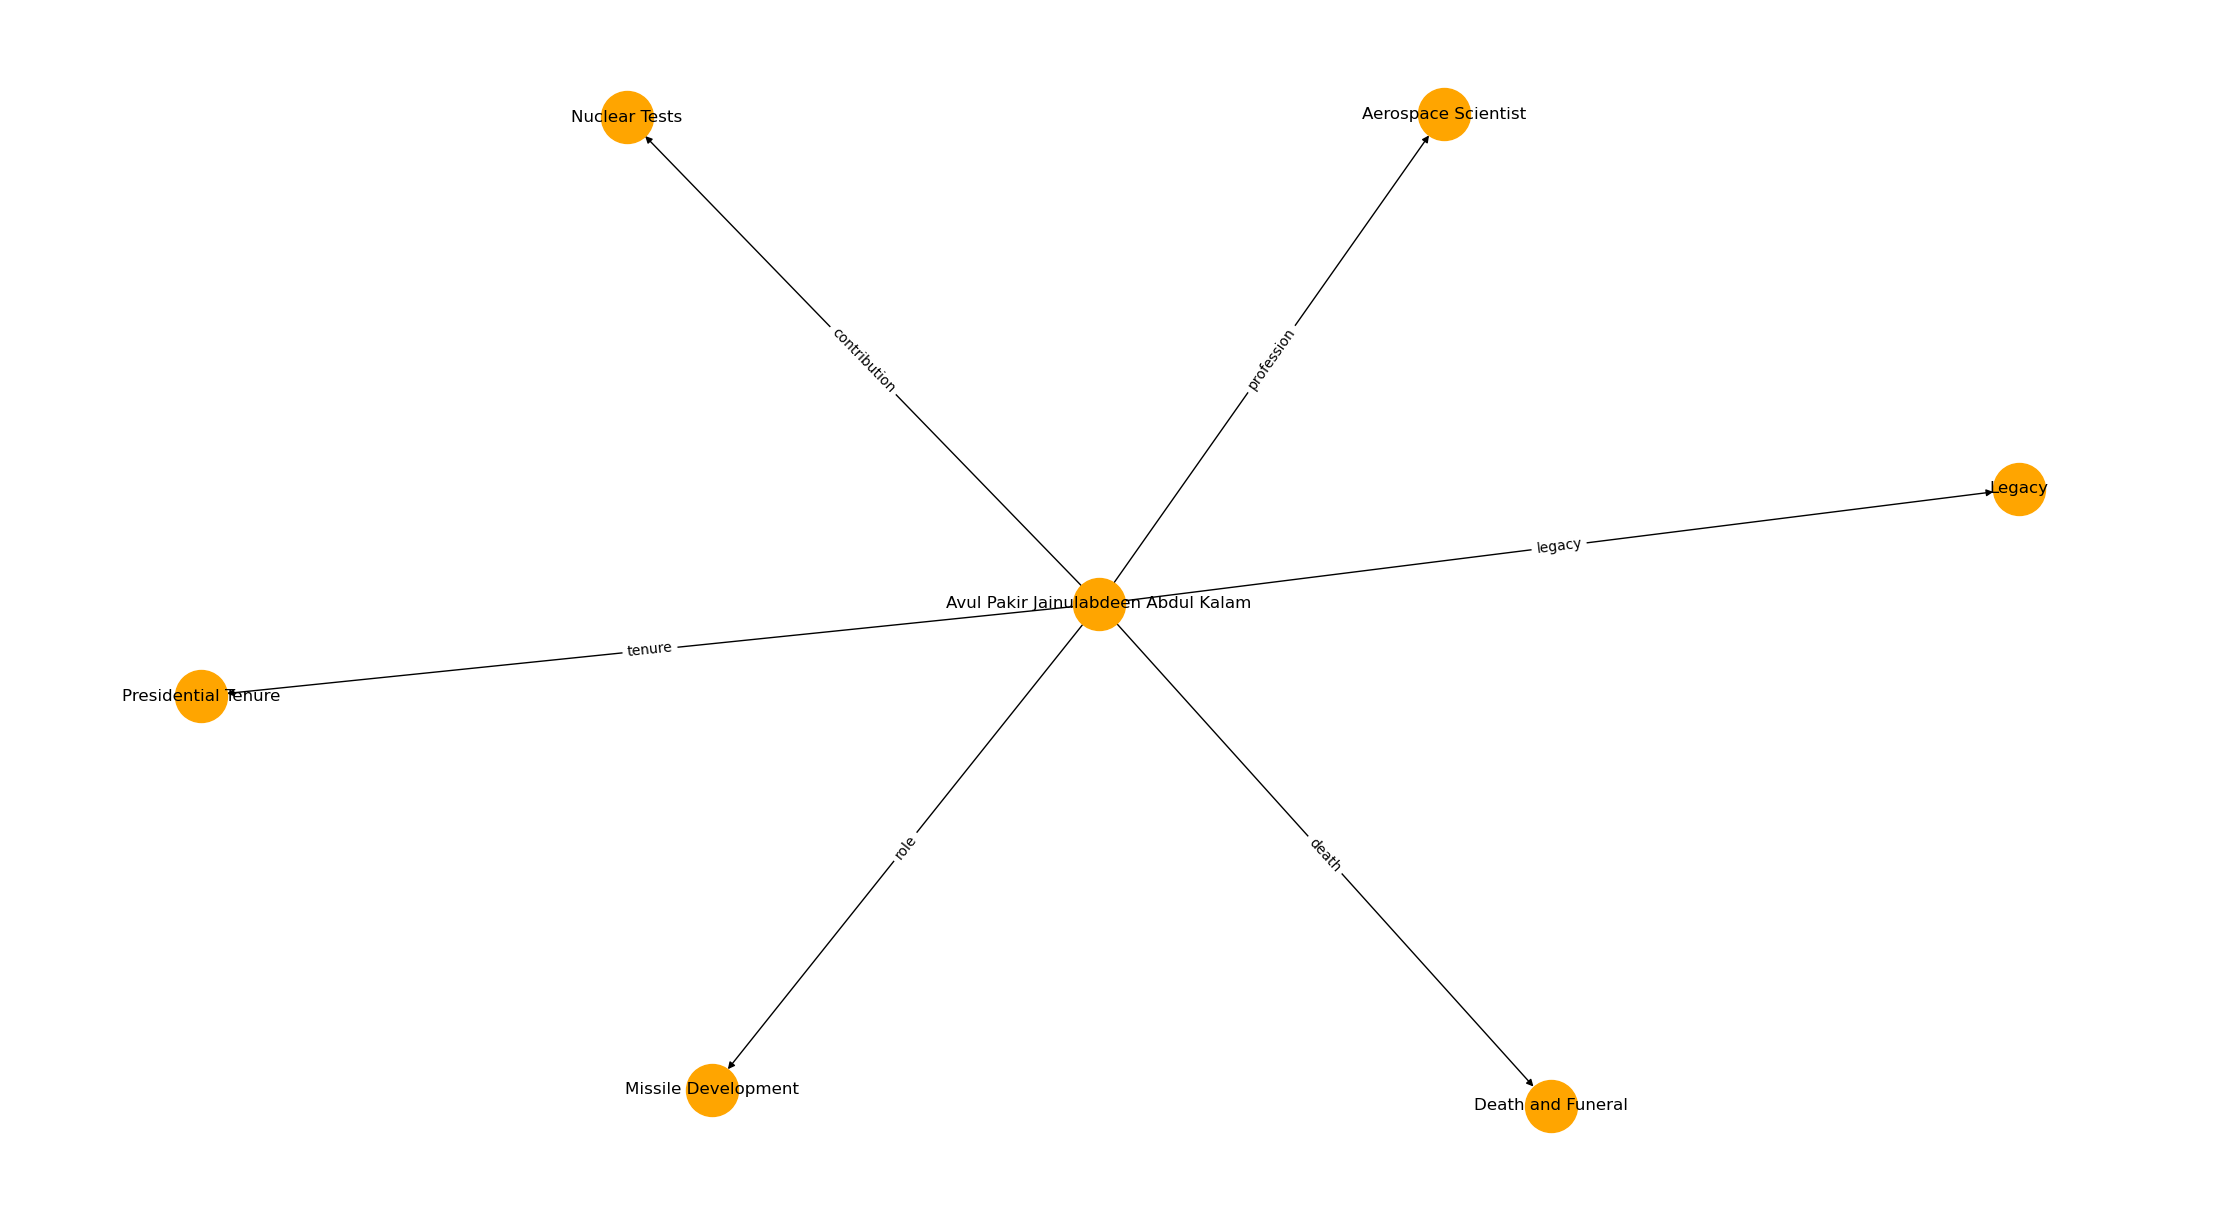

In [32]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for item in filtered_list_updated:
    # print(item[2])
    G.add_edge(item[0], item[2], label=item[1])

# Draw the graph
plt.figure(figsize=(22, 12))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=1400, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)})
plt.show()

### GraphRAG Implementation
- This line initializes a new instance of the `NetworkxEntityGraph` class, which is a wrapper for graph operations using the NetworkX library. -->
- This graph will be used to store and manipulate knowledge triples.

In [ ]:
# Import NetworkxEntityGraph from langchain.indexes.graph, a class for creating and managing entity graphs using NetworkX
from langchain.indexes.graph import NetworkxEntityGraph
graph = NetworkxEntityGraph()


This loop iterates over each triple in the filtered_list_updated. <br>
For each triple, it creates a new KnowledgeTriple object with the elements of the triple as its subject, predicate, and object.
The KnowledgeTriple class is a named tuple that represents a triple in the graph, consisting of a subject, predicate, and object.

In [43]:
for item in filtered_list_updated:
    kt = KnowledgeTriple(item[0], item[1], item[2])
    
    # This line adds the created KnowledgeTriple object to the graph.
    # The add_triple method of the NetworkxEntityGraph class is used to add the triple to the graph.
    # This method ensures that nodes for the subject and object of the triple are created if they do not already exist in the graph.
    # It also adds an edge between the subject and object nodes, with the predicate as the relation attribute of the edge.
    graph.add_triple(kt)

- This line initializes a GraphQAChain instance using the from_llm method.
- The llm parameter is set to the chat object, which is presumably an instance of a language model or a similar entity capable of processing natural language queries.
- The graph parameter is set to the previously created graph, which contains the knowledge triples.
- The verbose parameter is set to True, indicating that the chain will print intermediate logs to the console.

In [42]:
chain = GraphQAChain.from_llm(llm=gemini_model, graph=graph, verbose=True)

# This line runs the GraphQAChain with the query "Who is the CEO of Tesla".
# The run method processes the query using the knowledge graph and the language model to find an answer.
# The result of the query is stored in the variable res.
res = chain.run("Missile Development?")

# This line prints the result of the query to the console.
print(res)



> Entering new GraphQAChain chain...
Entities Extracted:
NONE
Full Context:


> Finished chain.
I do not know the answer to this question.


In [21]:
chain = GraphQAChain.from_llm(llm = chat, graph=graph, verbose=True)
res = chain.run("What is the specialization of Tesla")
print(res)



> Entering new GraphQAChain chain...
Entities Extracted:
Tesla
Full Context:
Tesla is American company
Tesla based in Austin, Texas
Tesla specializes in electric vehicles, clean energy products, related services
Tesla founded by Martin Eberhard, Marc Tarpenning
Tesla introduced several car models
Tesla reached market capitalization $1 trillion
Tesla leading battery electric vehicle market 19.9% share
Tesla ranked 69th Forbes Global 2000
Tesla most valuable automaker
Tesla faced legal challenges, regulatory scrutiny, criticism

> Finished chain.
Tesla specializes in electric vehicles, clean energy products, and related services.


In [45]:
chain = GraphQAChain.from_llm(llm = gemini_model, graph=graph, verbose=True)
res = chain.run("Who is the Avul Pakir Jainulabdeen Abdul Kalam?")
print(res)



> Entering new GraphQAChain chain...
Entities Extracted:
Avul Pakir Jainulabdeen Abdul Kalam
Full Context:
Avul Pakir Jainulabdeen Abdul Kalam profession Aerospace Scientist
Avul Pakir Jainulabdeen Abdul Kalam role Missile Development
Avul Pakir Jainulabdeen Abdul Kalam contribution Nuclear Tests
Avul Pakir Jainulabdeen Abdul Kalam tenure Presidential Tenure
Avul Pakir Jainulabdeen Abdul Kalam legacy Legacy
Avul Pakir Jainulabdeen Abdul Kalam death Death and Funeral

> Finished chain.
Avul Pakir Jainulabdeen Abdul Kalam was an Indian aerospace scientist who played a leading role in the development of India's missile and nuclear weapons programs. He served as the 11th President of India from 2002 to 2007.
